# Machine learning for trading (Gold)


## Data loading


In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from sklearn.preprocessing import MinMaxScaler
!pip install mplfinance

import warnings
warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
## Load yfinance Gold data
yf = False

if yf:
  import yfinance as yf
  # Define the ticker symbol
  tickerSymbol = 'GC=F'
  # Get the data for this ticker
  tickerData = yf.Ticker(tickerSymbol)
  # Get the historical prices for this ticker
  data = tickerData.history(period='1d', start='2012-7-12')
else:
  data = pd.read_csv('gc_data_2012_2023_tradingview.csv')

In [ ]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,7/18/2023,"1,980.30","1,958.30","1,988.30","1,958.10",NaN,NaN
1,7/17/2023,"1,958.90","1,959.00","1,963.55","1,949.25",NaN,0.05%
2,7/14/2023,"1,964.40","1,965.20","1,967.80","1,954.70",NaN,0.03%
3,7/13/2023,"1,963.80","1,962.70","1,968.50","1,956.60",241.22K,0.11%
4,7/12/2023,"1,961.70","1,938.00","1,965.10","1,937.50",270.87K,1.27%
...,...,...,...,...,...,...,...
2981,1/9/2012,"1,608.10","1,617.70","1,624.60","1,605.70",134.39K,-0.54%
2982,1/6/2012,"1,616.80","1,622.40","1,632.30","1,609.00",155.21K,-0.20%
2983,1/5/2012,"1,620.10","1,614.40","1,626.80","1,597.70",176.47K,0.46%
2984,1/4/2012,"1,612.70","1,604.90","1,619.80","1,593.80",154.22K,0.76%


## Check GPU


In [ ]:
if yf:
  data = data.drop(['Dividends','Volume', 'Stock Splits'],axis = 1)
  data.columns = ['Open', 'High', 'Low', 'Close']
else:
  data['Date'] = pd.to_datetime(data['Date'])
  data.index = data.Date
  data = data.loc['07-12-2012':]
  data = data.drop(['Vol.', 'Change %', 'Date'], axis=1)
  data.columns = ['Close','Open', 'High', 'Low']
  data['Close'] = data['Close'].str.replace(',', '').astype(float)
  data['Open'] = data['Open'].str.replace(',', '').astype(float)
  data['High'] = data['High'].str.replace(',', '').astype(float)
  data['Low'] = data['Low'].str.replace(',', '').astype(float)

data = data.dropna()
data = data.sort_values(by="Date", ascending=True)
data.to_csv('gcdata.csv')
#data.columns = ['Date','Open', 'High', 'Low', 'Close']


## Plotting the market data


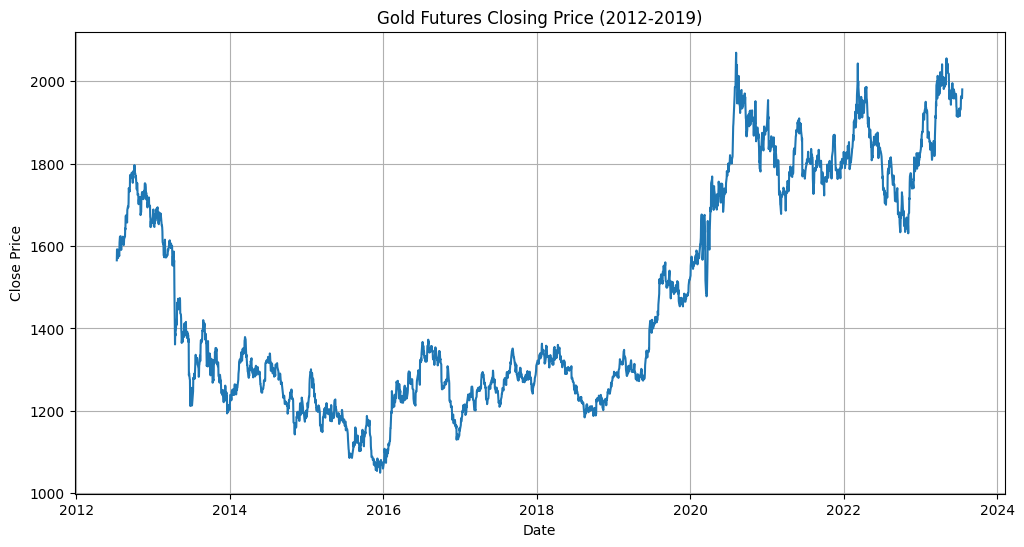

In [ ]:
# Plotting
plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.title('Gold Futures Closing Price (2012-2019)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

In [ ]:
data_raw = data.copy()

In [ ]:
data_raw.head()

,Close,Open,High,Low
Date,,,,
2012-07-12,1565.3,1576.3,1577.9,1554.4
2012-07-13,1592.0,1571.2,1596.5,1565.6
2012-07-16,1591.6,1591.5,1594.6,1577.2
2012-07-17,1589.5,1588.6,1598.8,1571.0
2012-07-18,1570.8,1583.0,1585.7,1567.2


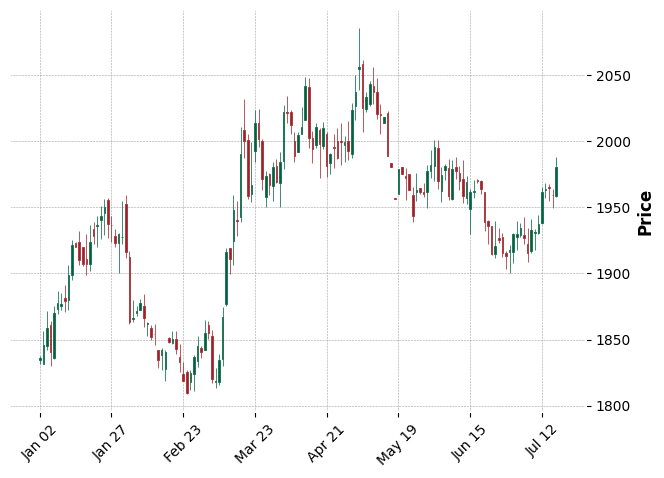

In [ ]:
import mplfinance as mpf
mpf.plot(data.loc['01-01-2023':],type='candle', style='charles')

In [ ]:
#data_raw.to_csv("gc_data_2012_2023Jul.csv")

## Defining the features


In [ ]:
#defining the features
def featurize(data, fast=7, slow=21, twoslow=35):
  data['Close_1'] = data['Close'].shift(1)
  data['maFast'] = data['Close'].ewm(span=fast, adjust=False).mean()
  data['maSlow'] = data['Close'].ewm(span=slow, adjust=False).mean()
  data['ma2Slow'] = data['Close'].ewm(span=twoslow, adjust=False).mean()
  data['closeMinusMaFast'] = data.Close - data.maFast
  data['close1MinusMaFast'] = data.Close_1 - data.maFast
  data['closeMinusMaSlow'] = data.Close - data.maSlow
  #data['close1MinusMaSlow'] = data.Close_1 - data.maSlow
  data['MaFastMinusMaSlow'] = data.maFast - data.maSlow
  data['MaFastMinusMa2Slow'] = data.maFast - data.ma2Slow
  data['MaSlowMinusMa2Slow'] = data.maSlow - data.ma2Slow
  data['returnToday'] = abs(data.Close - data.Open)
  data['returnNextDay'] = data.returnToday.shift(-1)

  returnRange = data.Close - data.Open
  data['candleToday'] = [1 if var > 0 else 0 for var in returnRange]
  data['candleNextDay'] = data.candleToday.shift(-1)
  # Add lagged features for the closing price
  for i in range(1, 8):
      data[f'candlelag_{i}'] = data.candleToday.shift(i)
  data['sum_bull_lag'] = (data['candleToday'] + data['candlelag_1'] + data['candlelag_2'] + data['candlelag_3'] + data['candlelag_4'] + data['candlelag_5'])/6

  data['CloseTomaFast'] = [1 if var > i else 0 for var,i in list(zip(data.Close, data.maFast))]
  for i in range(1, 8):
      data[f'CloseTomaFast_{i}'] = data.CloseTomaFast.shift(i)
  data['sum_clvsemafast_lag'] = (data['CloseTomaFast'] + data['CloseTomaFast_1'] + data['CloseTomaFast_2'] + data['CloseTomaFast_3'] + data['CloseTomaFast_4'] + data['CloseTomaFast_5'])/6

  data['CloseTomaSlow'] = [1 if var > i else 0 for var,i in list(zip(data.Close, data.maSlow))]
  for i in range(1, 8):
      data[f'CloseTomaSlow_{i}'] = data.CloseTomaSlow.shift(i)
  data['sum_clvsemaslow_lag'] = (data['CloseTomaSlow'] + data['CloseTomaSlow_1'] + data['CloseTomaSlow_2'] + data['CloseTomaSlow_3'] + data['CloseTomaSlow_4'] + data['CloseTomaSlow_5'])/6

  data['maFastTomaSlow'] = [1 if var > i else 0 for var,i in list(zip(data.maFast, data.maSlow))]
  for i in range(1, 8):
      data[f'maFastTomaSlow_{i}'] = data.maFastTomaSlow.shift(i)
  data['sum_mafastvsemaslow_lag'] = (data['maFastTomaSlow'] + data['maFastTomaSlow_1'] + data['maFastTomaSlow_2'] + data['maFastTomaSlow_3'] + data['maFastTomaSlow_4'] + data['maFastTomaSlow_5'])/6


  return data

In [ ]:
data.tail()

,Close,Open,High,Low
Date,,,,
2023-07-12,1961.7,1938.0,1965.10,1937.50
2023-07-13,1963.8,1962.7,1968.50,1956.60
2023-07-14,1964.4,1965.2,1967.80,1954.70
2023-07-17,1958.9,1959.0,1963.55,1949.25
2023-07-18,1980.3,1958.3,1988.30,1958.10


### other features


## Train and test set


In [ ]:
drop_feature_list = ['Open','High','Low','Close','maFast','maSlow', 'ma2Slow','candleNextDay','returnNextDay','returnToday',
                       'candlelag_3', 'candlelag_4','candlelag_5', 'candlelag_6', 'CloseTomaFast_3',  'CloseTomaFast_4',
                       'CloseTomaFast_5',  'CloseTomaFast_6','CloseTomaSlow_3','CloseTomaSlow_4', 'CloseTomaSlow_5', 'CloseTomaSlow_6',
                       'candlelag_2', 'CloseTomaFast_2', 'CloseTomaSlow_2','maFastTomaSlow_2', 'maFastTomaSlow_3', 'maFastTomaSlow_4',
                       'maFastTomaSlow_5', 'maFastTomaSlow_6',
                       'Close_1',
                        #'MaFastMinusMa2Slow'
                       ]

#normalise features
feature_list = ['MaFastMinusMaSlow', 'MaFastMinusMa2Slow', 'MaSlowMinusMa2Slow',
                  'closeMinusMaFast', 'closeMinusMaSlow', 'close1MinusMaFast',
                  'close1MinusMaSlow']

def train_validate(data = data, tsplit=1000, estimators=1000, fast=7, slow=21, twoslow=35):

  #Generate features
  data = featurize(data, fast, slow, twoslow)
  data = data.dropna()

  #Define the training set
  X = data.drop(drop_feature_list, axis = 1)
  Y = data.candleNextDay
  returns = data.returnNextDay
  X.tail(5)

  #train_test split - temporal split
  tsplit = 2500
  XTrain = X[:tsplit]
  YTrain = Y[:tsplit]
  returnsTrain = returns[:tsplit]

  #Normalize
  for feature in feature_list:
    if feature in XTrain.columns:
      minmaxsc_1 = MinMaxScaler()
      XTrain[feature] = minmaxsc_1.fit_transform(XTrain[feature].values.reshape(-1,1))
    else:
      pass


  return XTrain, YTrain


In [ ]:
train = train_validate(data_raw, 2500, 7, 21, 35)

In [ ]:
train

,closeMinusMaFast,close1MinusMaFast,closeMinusMaSlow,MaFastMinusMaSlow,MaFastMinusMa2Slow,MaSlowMinusMa2Slow,candleToday,candlelag_1,candlelag_7,sum_bull_lag,...,CloseTomaFast_7,sum_clvsemafast_lag,CloseTomaSlow,CloseTomaSlow_1,CloseTomaSlow_7,sum_clvsemaslow_lag,maFastTomaSlow,maFastTomaSlow_1,maFastTomaSlow_7,sum_mafastvsemaslow_lag
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-23,0.583577,0.597937,0.542685,0.463736,0.463736,0.0,0,1.0,0.0,0.666667,...,0.0,0.833333,1,1.0,0.0,1.000000,1,1.0,0.0,1.0
2012-07-24,0.579390,0.580120,0.539039,0.463082,0.463082,0.0,1,0.0,1.0,0.666667,...,1.0,0.833333,1,1.0,1.0,1.000000,1,1.0,1.0,1.0
2012-07-25,0.663938,0.566485,0.612488,0.475437,0.475437,0.0,1,1.0,1.0,0.666667,...,1.0,0.833333,1,1.0,1.0,1.000000,1,1.0,1.0,1.0
2012-07-26,0.674334,0.656554,0.624013,0.488700,0.488700,0.0,1,1.0,1.0,0.833333,...,1.0,1.000000,1,1.0,1.0,1.000000,1,1.0,1.0,1.0
2012-07-27,0.685386,0.666574,0.636291,0.502923,0.502923,0.0,1,1.0,0.0,0.833333,...,0.0,1.000000,1,1.0,1.0,1.000000,1,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-23,0.585215,0.532565,0.583274,0.648431,0.648431,0.0,1,0.0,0.0,0.500000,...,1.0,0.333333,1,1.0,1.0,1.000000,1,1.0,1.0,1.0
2022-03-24,0.650548,0.574212,0.638005,0.648434,0.648434,0.0,1,1.0,0.0,0.666667,...,0.0,0.500000,1,1.0,1.0,1.000000,1,1.0,1.0,1.0
2022-03-25,0.622122,0.647744,0.613266,0.644076,0.644076,0.0,0,1.0,0.0,0.500000,...,0.0,0.500000,1,1.0,1.0,1.000000,1,1.0,1.0,1.0
